## DS3000 Final Project Code

In this notebook, it shows all of the trials that our group went over in order to find the most optimal model for our dataset and why certain things were used/altered to get to our final design.

#### Our Dataset

Our dataset is based on used car prices. The first thing that our group needed to do is to read the csv file and to assess the types of data contained inside of this set.

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score, KFold
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor



In [9]:
#reading the file for data we will use 
data = pd.read_csv('used_cars.csv', header=None)
data.columns = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission',  'ext_col', 'int_col', 'accident', 'clean_title','price' ]
#data = data.drop(columns=['engine','transmission', 'fuel_type', 'ext_col', 'int_col'])
data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


## Mapping the Values

Since the head contained a lot of string values and other numerical values with concatinations, we needed to find a way to transform all of the data into numerical values so they can be plotted and used in each of the machine learning models. 

Initially, we had thousands of unique values for some categories (transmission, engine, etc). These were also grouped together to further simplify the raw data.

In [10]:

# Define grouping rules for transmission
def map_transmission(value): 
    value_lower = value.lower()  # Normalize to lowercase for easier matching
    if any(keyword in value_lower for keyword in ['automatic', 'a/t', 'cvt']):
        return 'Automatic'
    elif any(keyword in value_lower for keyword in ['manual', 'm/t']):
        return 'Manual'
    else:
        return 'Other'


def map_engine(value):
    value_lower = value.lower()  # Normalize to lowercase for easier matching
    if '4 cylinder' in value_lower or '4-cylinder' in value_lower:
        return '4-cylinder'
    elif '6 cylinder' in value_lower or '6-cylinder' in value_lower or 'v6' in value_lower:
        return '6-cylinder'
    elif '8 cylinder' in value_lower or '8-cylinder' in value_lower or 'v8' in value_lower:
        return '8-cylinder'
    elif '12 cylinder' in value_lower or '12-cylinder' in value_lower:
        return '12-cylinder'
    else:
        return 'Other'



# Cleaning mileage: remove "mi." and commas, then convert to integer
data['milage'] = data['milage'].str.replace(' mi.', '').str.replace(',', '').astype(float)

#Cleaning price: remove "$" and commas, then convert to float
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)

#Handling missing values in 'clean_title': fill NaN with "Unknown"
data['clean_title'] = data['clean_title'].fillna('Unknown')
data['transmission'] = data['transmission'].apply(map_transmission)
data['engine'] = data['engine'].apply(map_engine)
# Encoding 'brand' and 'model' to numerical values while saving mappings
brand_mapping = {brand: idx for idx, brand in enumerate(data['brand'].unique())}
model_mapping = {model: idx for idx, model in enumerate(data['model'].unique())}
fuel_mapping = {fuel_type: idx for idx, fuel_type in enumerate(data['fuel_type'].unique())}
engine_mapping = {engine: idx for idx, engine in enumerate(data['engine'].unique())}
transmission_mapping = {transmission: idx for idx, transmission in enumerate(data['transmission'].unique())}
ext_col_mapping = {ext_col: idx for idx, ext_col in enumerate(data['ext_col'].unique())}
int_col_mapping = {int_col: idx for idx, int_col in enumerate(data['int_col'].unique())}
accident_mapping = {accident: idx for idx, accident in enumerate(data['accident'].unique())}
clean_title_mapping = {clean_title: idx for idx, clean_title in enumerate(data['clean_title'].unique())}

data['brand'] = data['brand'].map(brand_mapping)
data['model'] = data['model'].map(model_mapping)
data['fuel_type'] = data['fuel_type'].map(fuel_mapping)
data['engine'] = data['engine'].map(engine_mapping)
data['transmission'] = data['transmission'].map(transmission_mapping)
data['ext_col'] = data['ext_col'].map(ext_col_mapping)
data['int_col'] = data['int_col'].map(int_col_mapping)
data['accident'] = data['accident'].map(accident_mapping)
data['clean_title'] = data['clean_title'].map(clean_title_mapping)



# Save the mappings as DataFrames for reference
brand_mapping_df = pd.DataFrame(list(brand_mapping.items()), columns=['Brand', 'Encoded_Value'])
model_mapping_df = pd.DataFrame(list(model_mapping.items()), columns=['Model', 'Encoded_Value'])
fuel_mapping_df = pd.DataFrame(list(fuel_mapping.items()), columns=['Fuel Type', 'Encoded_Value'])
engine_mapping_df = pd.DataFrame(list(engine_mapping.items()), columns=['Engine', 'Encoded_Value'])
transmission_mapping_df = pd.DataFrame(list(transmission_mapping.items()), columns=['Transmission', 'Encoded_Value'])
ext_col_mapping_df = pd.DataFrame(list(ext_col_mapping.items()), columns=['Exterior Colour', 'Encoded_Value'])
int_col_mapping_df = pd.DataFrame(list(int_col_mapping.items()), columns=['Interior Colour', 'Encoded_Value'])
accident_mapping_df = pd.DataFrame(list(accident_mapping.items()), columns=['Accidents', 'Encoded_Value'])
clean_title_mapping_df = pd.DataFrame(list(clean_title_mapping.items()), columns=['Clean Title', 'Encoded_Value'])


# Display the cleaned dataset and the mapping DataFrames
# Display the cleaned dataset and all mapping DataFrames
print("Cleaned Dataset:")
print(data.head())

print("\nBrand Mapping:")
print(brand_mapping_df.head())

print("\nModel Mapping:")
print(model_mapping_df.head())

print("\nFuel Type Mapping:")
print(fuel_mapping_df.head())





Cleaned Dataset:
   brand  model  model_year   milage  fuel_type  engine  transmission  \
0      0      0        2013  51000.0          0       0             0   
1      1      1        2021  34742.0          1       0             0   
2      2      2        2022  22372.0          1       1             0   
3      3      3        2015  88900.0          2       0             0   
4      4      4        2021   9835.0          1       1             0   

   ext_col  int_col  accident  clean_title    price  
0        0        0         0            0  10300.0  
1        1        1         0            0  38005.0  
2        2        0         1            1  54598.0  
3        0        0         1            0  15500.0  
4        3        0         1            1  34999.0  

Brand Mapping:
      Brand  Encoded_Value
0      Ford              0
1   Hyundai              1
2     Lexus              2
3  INFINITI              3
4      Audi              4

Model Mapping:
                          

In [4]:
print("\nEngine Mapping:")
print(engine_mapping_df.head())

print("\nTransmission Mapping:")
print(transmission_mapping_df.head())

print("\nExterior Colour Mapping:")
print(ext_col_mapping_df.head())




Engine Mapping:
        Engine  Encoded_Value
0   6-cylinder              0
1        Other              1
2   4-cylinder              2
3   8-cylinder              3
4  12-cylinder              4

Transmission Mapping:
  Transmission  Encoded_Value
0    Automatic              0
1        Other              1
2       Manual              2

Exterior Colour Mapping:
          Exterior Colour  Encoded_Value
0                   Black              0
1         Moonlight Cloud              1
2                    Blue              2
3  Glacier White Metallic              3
4                  Silver              4


In [5]:
print("\nInterior Colour Mapping:")
print(int_col_mapping_df.head())

print("\nAccident Mapping:")
print(accident_mapping_df)

print("\nClean Title Mapping:")
print(clean_title_mapping_df)


Interior Colour Mapping:
   Interior Colour  Encoded_Value
0            Black              0
1             Gray              1
2           Ebony.              2
3            Green              3
4  Pimento / Ebony              4

Accident Mapping:
                                Accidents  Encoded_Value
0  At least 1 accident or damage reported              0
1                           None reported              1
2                                     NaN              2

Clean Title Mapping:
  Clean Title  Encoded_Value
0         Yes              0
1     Unknown              1


## Heatmap for Correlations

A heatmap was then created to see if there were any individual correlations of a feature to price.

Since there was not any, it suggested to our group that a more detailed model will need to be used.

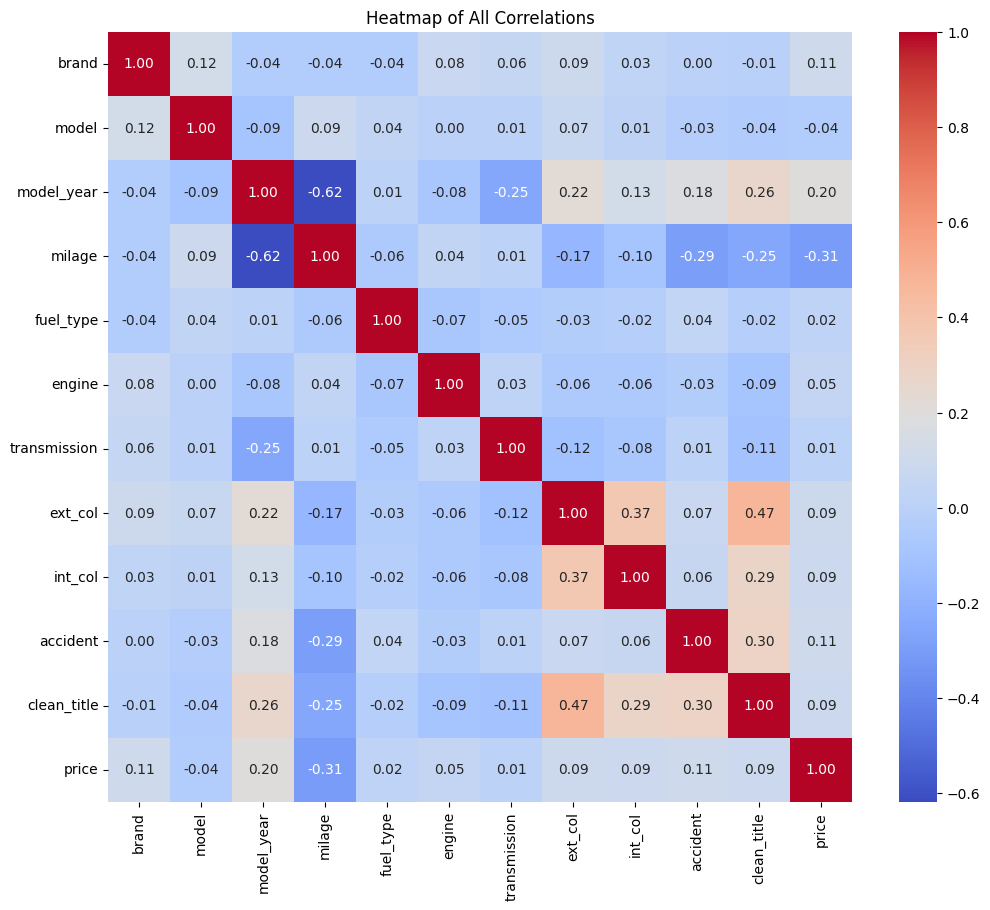

In [6]:
#Creating heatmaps for the data to find correlations
corr_matrix = data.corr()

plt.figure(figsize=(12,10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Heatmap of All Correlations")

plt.show()

## Plotting the data

We also plotted each of the features in comparison to the price in order to see any trends that could help in picking a model or to group certain features together.

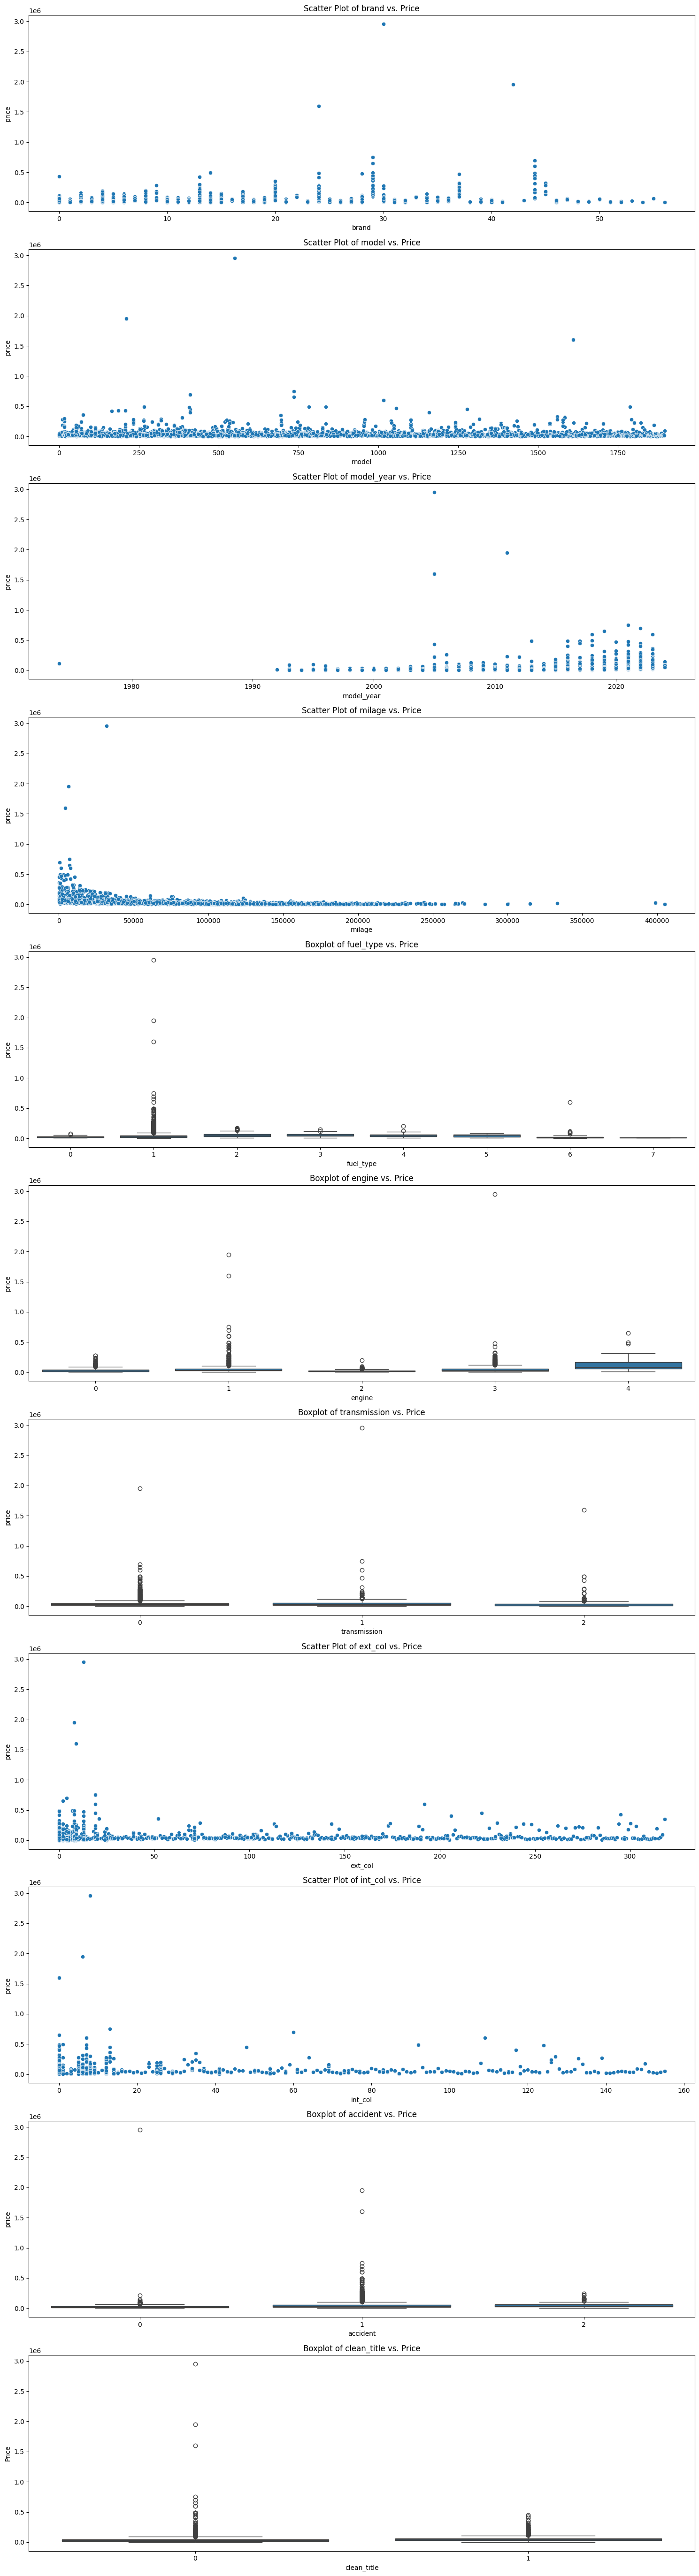

In [7]:
#plots vs price to show correlations

columns = data.columns.drop('price')

plt.figure(figsize=(15, len(columns) * 5))

#loop to create all plots
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)

    if data[col].nunique() < 20:
        sns.boxplot(x=data[col], y=data['price'])
        plt.title(f'Boxplot of {col} vs. Price')
    else:
        sns.scatterplot(x=data[col], y=data['price'])
        plt.title(f'Scatter Plot of {col} vs. Price')

plt.xlabel(col)
plt.ylabel('Price')

plt.tight_layout()
plt.show()

## Linear Regression

First created a linear regression model to serve as our base model.

Coeff:  [  6062.28171074  -1245.83728792   7515.95392527 -16237.68200557
   2323.00624169   4890.84543321   1209.40772865   2773.03920061
   4063.33447704   3222.36014894  -1988.75754043]
Intercept:  43125.756782039185
Mean Absolute Error (MAE): 30835.979407252016
Root Mean Squared Error (RMSE): 140420.87005934096
R² Score: 0.035301636090286026


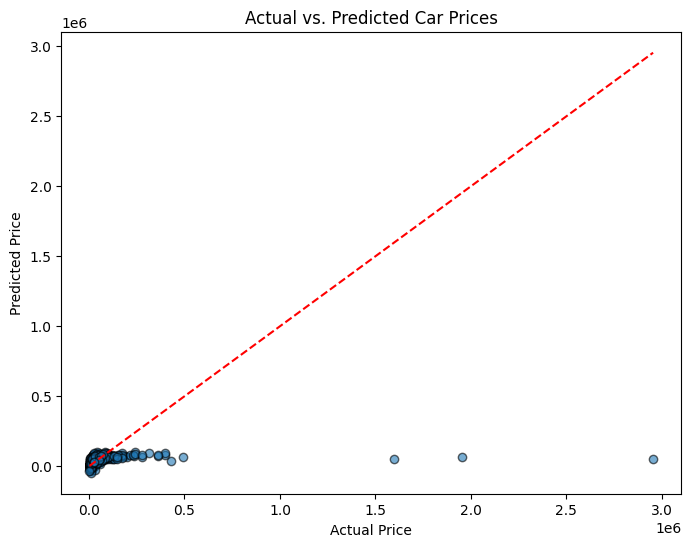

In [11]:


X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize Dataset
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

lr = LinearRegression()

lr.fit(X_train_std, y_train)

print("Coeff: ", lr.coef_)
print("Intercept: ", lr.intercept_)

y_pred = lr.predict(X_test_std)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Car Prices')
plt.show()




## XGBoost

Completed XGBoost and saw better results but still no where near where it needs to be.

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mean Absolute Error (MAE): 19724.73225505572
Root Mean Squared Error (RMSE): 137062.9108740489
R² Score: 0.0808886598494668


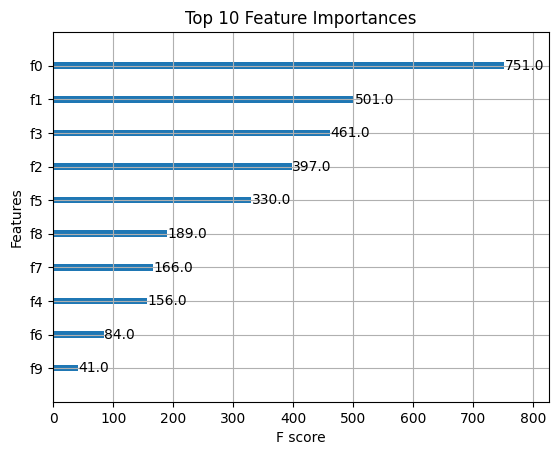

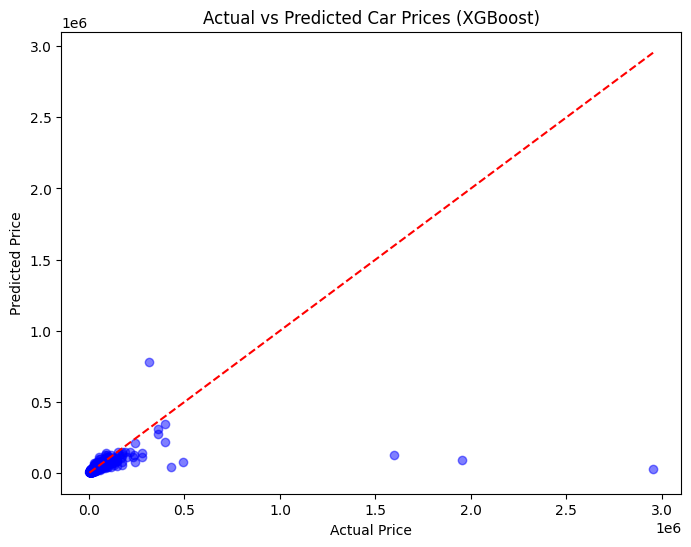

Cross-Validation RMSE: 0.358513694008155


In [9]:

# Log-transform the price to handle skewness (optional)
y_train_log = np.log1p(y_train)  # Log-transform target
y_test_log = np.log1p(y_test)    # Log-transform target

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Narrow the hyperparameter search space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),  # Limit number of estimators
    'learning_rate': uniform(0.05, 0.1),  # Smaller learning rate range
    'max_depth': randint(3, 7),  # Reduced max depth range
    'subsample': uniform(0.7, 0.3),  # Use a moderate subsample range
    'colsample_bytree': uniform(0.7, 0.3),  # Same for column sample
    'min_child_weight': randint(1, 6),  # Reduced min child weight range
    'gamma': uniform(0, 0.5)  # Limited gamma range
}

# Perform Randomized Search Cross Validation
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=5, cv=3, verbose=1, random_state=42)
random_search.fit(X_train_std, y_train_log)  # Fit on log-transformed target

# Get the best model from RandomizedSearchCV
best_xgb_reg = random_search.best_estimator_

# Predict prices on the test set (after inverse log-transformation)
y_pred_log = best_xgb_reg.predict(X_test_std)
y_pred = np.expm1(y_pred_log)  # Inverse log-transform predictions

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot feature importance
xgb.plot_importance(best_xgb_reg, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# Scatter plot: Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect prediction line
plt.title("Actual vs Predicted Car Prices (XGBoost)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# Cross-validation score to evaluate model generalization
cv_scores = cross_val_score(best_xgb_reg, X_train_std, y_train_log, cv=5, scoring='neg_mean_squared_error')
mean_cv_rmse = np.mean(np.sqrt(-cv_scores))  # Convert MSE to RMSE
print(f"Cross-Validation RMSE: {mean_cv_rmse}")


## Decision Tree and KNN

Decision Tree and KNN was also implemented and performed similar to each other, but was worse than the XGBoost so we knew that it was not the model to use

In [10]:


# Initialize and train the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_std, y_train)

# Make predictions
y_pred = dt_regressor.predict(X_test_std)

# Evaluate the model
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 139815.16
R-squared (R2): 0.04


Mean Squared Error (MSE): 139745.21
R-squared (R2): 0.04


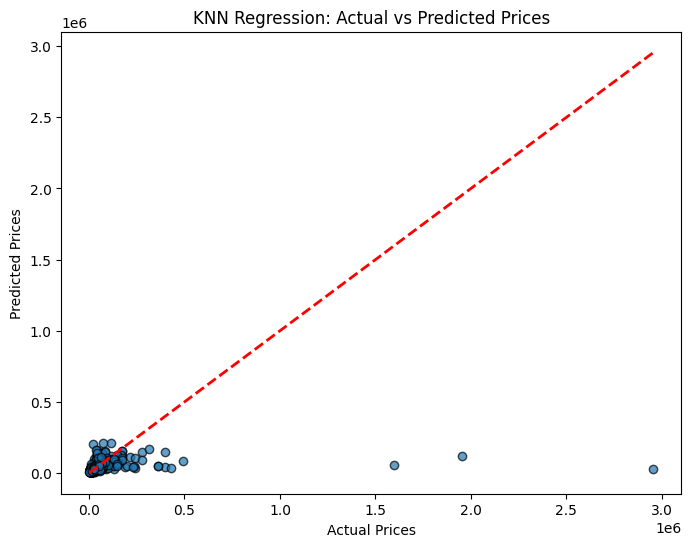

In [11]:

# Initialize the KNN Regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can change 'n_neighbors' to tune the model

# Train the model
knn_regressor.fit(X_train_std, y_train)

# Make predictions
y_pred = knn_regressor.predict(X_test_std)

# Evaluate the model
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot the actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("KNN Regression: Actual vs Predicted Prices")
plt.show()


## Random Forest 

We then did a random forest model which was similar to the XGBoost in performance, but we still had very high error scores and a very low $R^2$ value

Mean Squared Error (MSE): 133775.96272719183
R^2 Score: 0.12444306378612169

Feature Importances:
         Feature  Importance
3         milage    0.377209
0          brand    0.234987
5         engine    0.088736
8        int_col    0.067451
2     model_year    0.067107
1          model    0.066214
7        ext_col    0.056728
6   transmission    0.019869
4      fuel_type    0.008900
10   clean_title    0.008514
9       accident    0.004283


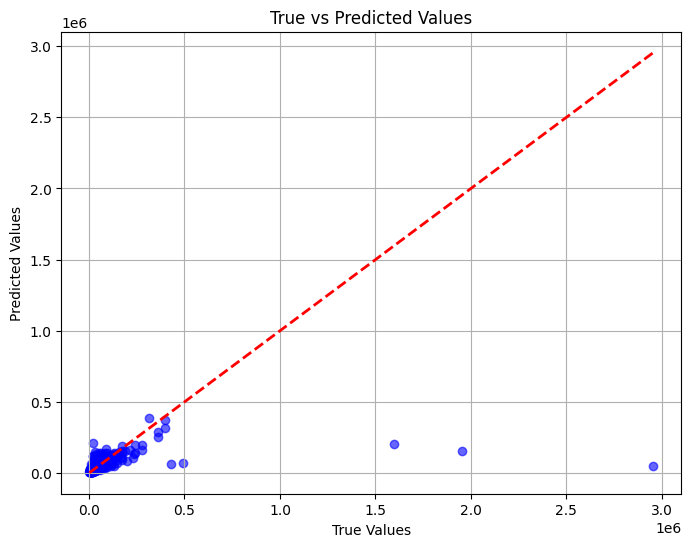

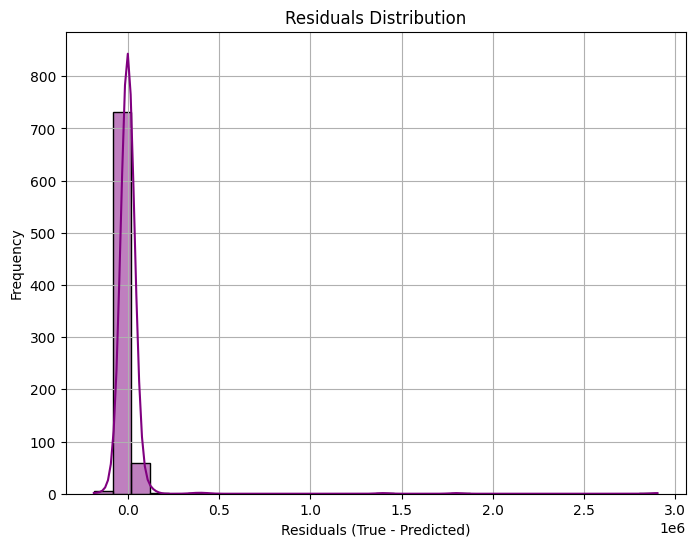

Mean Absolute Error (MAE): 21330.416845386535


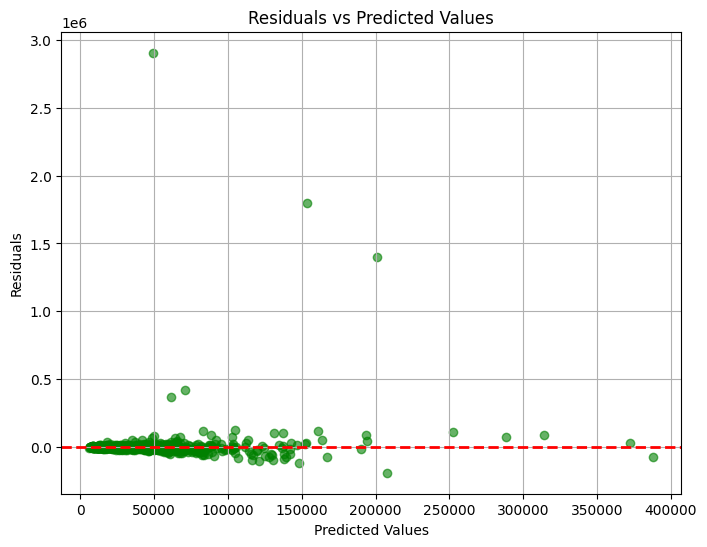

In [12]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train_std, y_train)

y_pred = rf_model.predict(X_test_std)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# Feature importance (optional)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot: True vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Diagonal line
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

# Plot: Residuals (Errors)
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (True - Predicted)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Mean Absolute Error (MAE) for the residual plot
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Residuals vs Predictions plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()


## Neural Network



In [13]:

# Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)  # Assuming X is your original feature matrix

# Scale the Data
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)


In [14]:

# Build the Neural Network
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001),),  # Hidden layer
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001),),  # Hidden layer
    Dense(1, activation='linear')  # Output layer
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Predict on Test Set
y_pred = model.predict(X_test)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"ANN with TensorFlow - Mean Absolute Error (MAE): {mae}")
print(f"ANN with TensorFlow - Root Mean Squared Error (RMSE): {rmse}")
print(f"ANN with TensorFlow - R² Score: {r2}")


C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5118153728.0000 - mae: 43535.2852 - val_loss: 4164515584.0000 - val_mae: 42066.0234
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3875904512.0000 - mae: 38057.7422 - val_loss: 2050971008.0000 - val_mae: 21377.2344
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2841903104.0000 - mae: 23106.0938 - val_loss: 1731628160.0000 - val_mae: 20817.6797
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2011525504.0000 - mae: 21691.9297 - val_loss: 1683710848.0000 - val_mae: 20840.0977
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1637639936.0000 - mae: 20245.1270 - val_loss: 1647950336.0000 - val_mae: 21122.1504
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1682405504.0000 - mae: 20887.1035 - val_loss: 1623294464.0000 - val_mae: 21278.0449
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1871092736.0000 - mae: 20883.1406 - val_loss: 1592416256.0000 - val_mae: 20467.0566
Epoch 

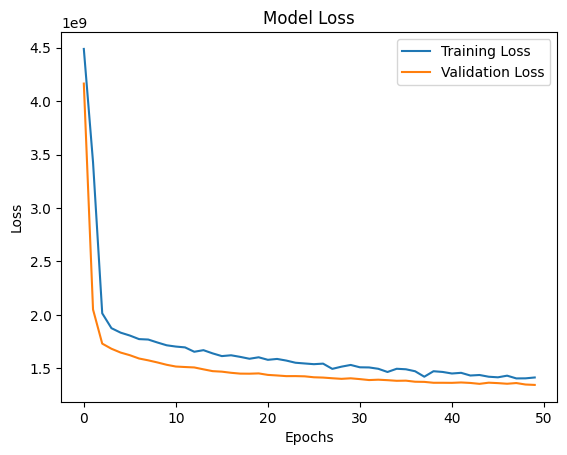

In [15]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Stacked Approach

The last model we tried to use the whole set for is a stacked approach, where data would enter into a XGBoost, Random Forest and Neural Network individually then the results of that would enter a Random Forest model. This approach although very complex and time consuming was our best model thus far but still no where near where it would needs to be 

In [16]:
#BEST MODEL SO FAR

# Build a neural network model using TensorFlow
def build_nn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    return model

# Fit TensorFlow model on the dataset
def fit_nn_model(X_train, y_train):
    model = build_nn_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=0)
    return model

# Base models: RandomForest, XGBoost, and TensorFlow Neural Network
def create_base_models():
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    xgb_model = xgb.XGBRegressor(n_estimators=200, subsample=0.8, max_depth=8, learning_rate=0.05, colsample_bytree=0.8, random_state=42)
    return rf_model, xgb_model

# Train the base models and make predictions
def train_and_predict_base_models(X_train, y_train, X_test):
    rf_model, xgb_model = create_base_models()

    # Train RandomForest and XGBoost models
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Train TensorFlow model
    nn_model = fit_nn_model(X_train, y_train)

    # Make predictions with base models
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    nn_preds = nn_model.predict(X_test).flatten()  # Flatten to match expected shape

    # Stack the predictions of base models as features for the meta-model
    stacked_preds = np.column_stack((rf_preds, xgb_preds, nn_preds))
    return stacked_preds

# Meta-model: Stacked Model using Random Forest or XGBoost
def fit_meta_model(X_train, y_train):
    # Use RandomForest or XGBoost as the meta-model
    meta_model = RandomForestRegressor(n_estimators=100, random_state=42)
    #meta_model = xgb.XGBRegressor(n_estimators=200, subsample=0.8, max_depth=8, learning_rate=0.05, colsample_bytree=0.8, random_state=42) # Uncomment to use XGBoost
    meta_model.fit(X_train, y_train)
    return meta_model

# Evaluate model performance
def evaluate_model(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(root_mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

# Split dataset (X_train, X_test, y_train, y_test)
# Assuming X_train, X_test, y_train, y_test are already defined

# Stack predictions of base models
stacked_preds_train = train_and_predict_base_models(X_train, y_train, X_train)
stacked_preds_test = train_and_predict_base_models(X_train, y_train, X_test)

# Train meta-model using the stacked predictions
meta_model = fit_meta_model(stacked_preds_train, y_train)

# Make predictions using meta-model
final_preds = meta_model.predict(stacked_preds_test)

# Evaluate the final predictions
mae, rmse, r2 = evaluate_model(y_test, final_preds)

print(f"Stacked Model - Mean Absolute Error (MAE): {mae}")
print(f"Stacked Model - Root Mean Squared Error (RMSE): {rmse}")
print(f"Stacked Model - R² Score: {r2}")


C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Stacked Model - Mean Absolute Error (MAE): 20079.150062344142
Stacked Model - Root Mean Squared Error (RMSE): 365.6215765608046
Stacked Model - R² Score: 0.12571004089030036


Stacked Model - Mean Absolute Error (MAE): 20079.150062344142
Stacked Model - Root Mean Squared Error (RMSE): 365.6215765608046
Stacked Model - R² Score: 0.12571004089030036


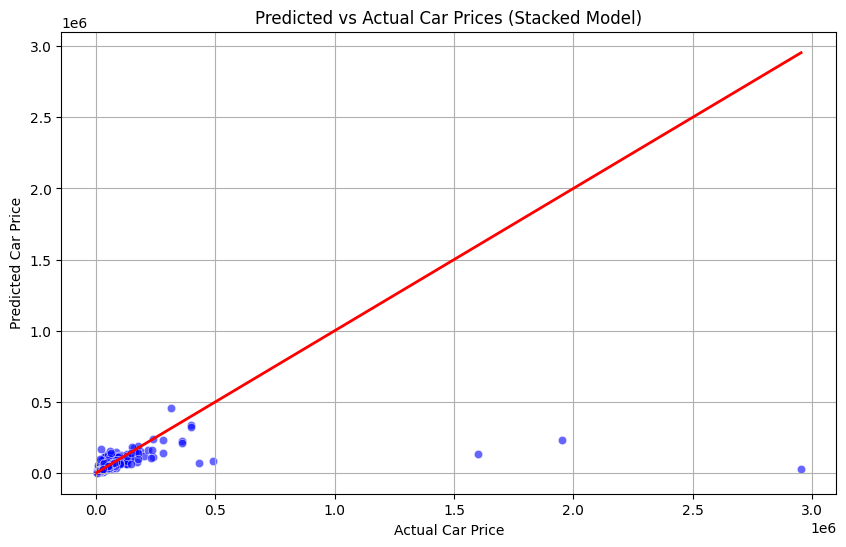

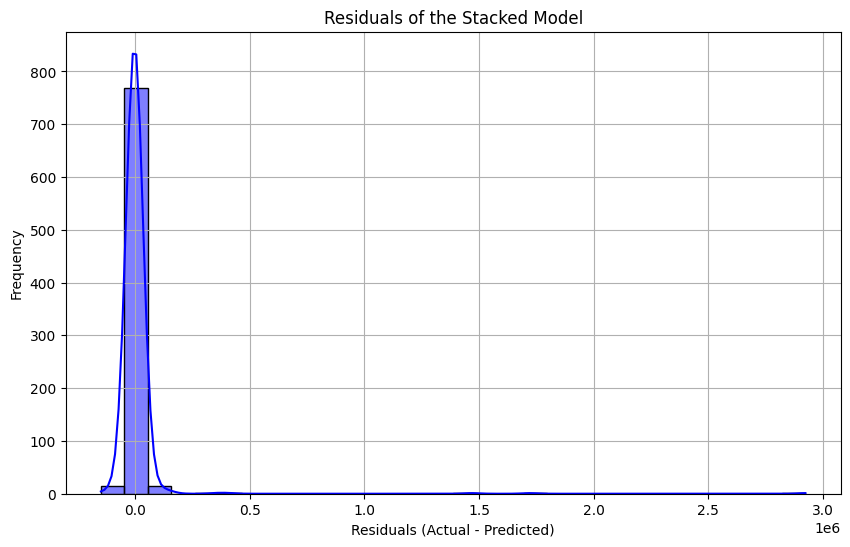

In [17]:


# Assuming you have already trained your stacked model and have predictions in `y_pred_stacked`
# And the actual values are in `y_test`
print(f"Stacked Model - Mean Absolute Error (MAE): {mae}")
print(f"Stacked Model - Root Mean Squared Error (RMSE): {rmse}")
print(f"Stacked Model - R² Score: {r2}")
# Plotting Predicted vs Actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_preds, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('Predicted vs Actual Car Prices (Stacked Model)')
plt.xlabel('Actual Car Price')
plt.ylabel('Predicted Car Price')
plt.grid(True)
plt.show()

# Plotting residuals (errors)
residuals = y_test - final_preds
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Residuals of the Stacked Model')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Splitting the Data

We noticed that every single iteration of the different models when plotted showed a very similar structure where a lot of terms were clustered near the low-end price and outliers started as price was higher. So we decided to take a closer look at the lower end of the model (price < 50000)

Low-Price Model Performance:
Mean Absolute Error (MAE): 13186.897504898512
Root Mean Squared Error (RMSE): 145.0583799692377
R² Score: -1.6533081671316898


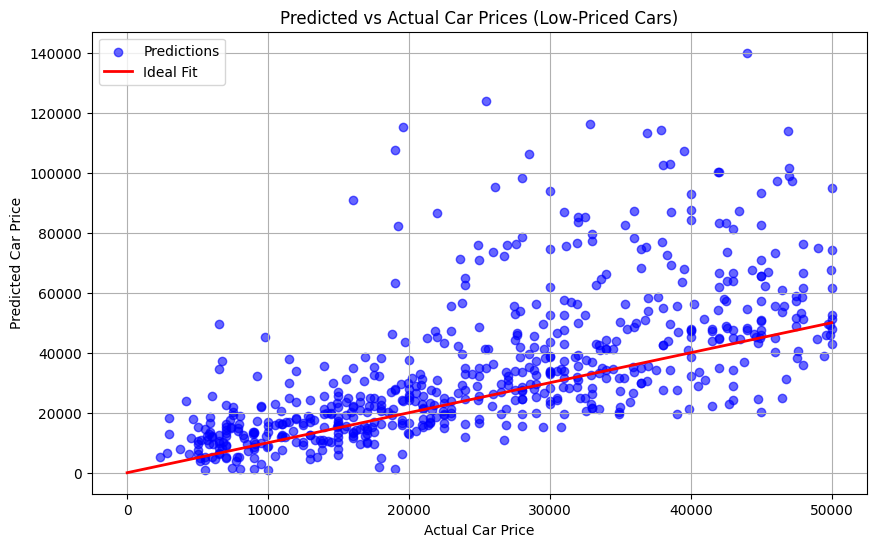

In [18]:


# Define the threshold for low car prices (e.g., below $50,000)
low_price_threshold = 50000

# Filter the test set to include only low-priced cars
low_price_indices = y_test <= low_price_threshold
y_test_low = y_test[low_price_indices]
y_pred_low = y_pred[low_price_indices]

# Calculate performance metrics for low-priced cars
mae_low = mean_absolute_error(y_test_low, y_pred_low)
rmse_low = np.sqrt(root_mean_squared_error(y_test_low, y_pred_low))
r2_low = r2_score(y_test_low, y_pred_low)

print(f"Low-Price Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_low}")
print(f"Root Mean Squared Error (RMSE): {rmse_low}")
print(f"R² Score: {r2_low}")

# Create a scatter plot for low-priced cars
plt.figure(figsize=(10, 6))
plt.scatter(y_test_low, y_pred_low, color='blue', alpha=0.6, label='Predictions')
plt.plot([0, low_price_threshold], [0, low_price_threshold], color='red', linewidth=2, label='Ideal Fit')
plt.title("Predicted vs Actual Car Prices (Low-Priced Cars)")
plt.xlabel("Actual Car Price")
plt.ylabel("Predicted Car Price")
plt.legend()
plt.grid(True)
plt.show()


## Breakdown of Price Ranges

Wanted to see the breakdown of how cars are distributed in the dataset.

In [12]:
price_ranges = {
    "Under 50000": (y < 50000).sum(),
    "50000-60000": ((y >= 50000) & (y < 60000)).sum(),
    "60000-70000": ((y >= 60000) & (y < 70000)).sum(),
    "70000-80000": ((y >= 70000) & (y < 80000)).sum(),
    "80000-90000": ((y >= 80000) & (y < 90000)).sum(),
    "90000-100000": ((y >= 90000) & (y < 100000)).sum(),
    "100000+": (y >= 100000).sum()
}

for range_label, count in price_ranges.items():
    print(f'{range_label}: {count}')

Under 50000: 3025
50000-60000: 263
60000-70000: 204
70000-80000: 118
80000-90000: 89
90000-100000: 75
100000+: 235


In [13]:


features = ['milage', 'model_year', 'brand', 'model', 'engine', 'transmission']
target = 'price'

low_priced_data = data[data['price'] < 70000]
high_priced_data = data[data['price'] >= 70000]

X_low = low_priced_data[features]
y_low = low_priced_data[target]

X_high = high_priced_data[features]
y_high = high_priced_data[target]

# One-hot encoding for categorical features
X_low = pd.get_dummies(X_low, drop_first=True)

X_high = pd.get_dummies(X_high, drop_first=True)


# Train-test split
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2, random_state=42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled_low = scaler.fit_transform(X_train_low)
X_test_scaled_low = scaler.transform(X_test_low)

X_train_scaled_high = scaler.fit_transform(X_train_high)
X_test_scaled_high = scaler.transform(X_test_high)

#method to find the best model for each of the sets of cars.
def ModelComparison(X_train_scaled, y_train, X_test_scaled, y_test):
    models = {
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42, objective="reg:squarederror"),
        "Linear Regression": LinearRegression()
    }

    # Hyperparameter grids for each model (Linear Regression has no hyperparameters to tune)
    param_grids = {
        "Gradient Boosting": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        "Random Forest": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        "XGBoost": {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
            'reg_lambda': [1, 2, 5]  # L2 regularization
        },
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        if model_name in param_grids:  # Perform grid search if hyperparameters are defined
            grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid_search.fit(X_train_scaled, y_train)

            # Best model
            best_model = grid_search.best_estimator_
        else:
            # Directly fit models without hyperparameters (e.g., Linear Regression)
            model.fit(X_train_scaled, y_train)
            best_model = model

        # Predictions and Metrics
        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"{model_name} Model Performance:")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"R² Score: {r2}")



print('For Low-Priced: ')
ModelComparison(X_train_scaled_low, y_train_low, X_test_scaled_low, y_test_low)
print('\nFor High-Priced: ')
ModelComparison(X_train_scaled_high, y_train_high, X_test_scaled_high, y_test_high)


For Low-Priced: 

Training Gradient Boosting...


C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Gradient Boosting Model Performance:
Mean Absolute Error (MAE): 5671.197947900952
Root Mean Squared Error (RMSE): 87.81880598829194
R² Score: 0.7787883675339735

Training Random Forest...
Random Forest Model Performance:
Mean Absolute Error (MAE): 6308.063476394848
Root Mean Squared Error (RMSE): 92.6523360006217
R² Score: 0.7259162153731407

Training XGBoost...
XGBoost Model Performance:
Mean Absolute Error (MAE): 5654.254384315065
Root Mean Squared Error (RMSE): 88.11909396397722
R² Score: 0.7757471655031811

Training Linear Regression...
Linear Regression Model Performance:
Mean Absolute Error (MAE): 9034.301144274617
Root Mean Squared Error (RMSE): 107.36190098585003
R² Score: 0.5058502052480929

For High-Priced: 

Training Gradient Boosting...
Gradient Boosting Model Performance:
Mean Absolute Error (MAE): 45004.78390937703
Root Mean Squared Error (RMSE): 309.0810744648269
R² Score: 0.19715976082552367

Training Random Forest...
Random Forest Model Performance:
Mean Absolute Error

C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Overall the XGBoost model performs the best on the high priced cars but still not ideal as $R^2$ value is 0.672. This could be from the lack of cars that are valued over $70,000 in the dataset thus the model cannot be accurate enough due to lack of data.

The low priced cars saw the best model being the Gradient Boosting model and XGBoost model giving relatively good values across. There is still room for improvement, however the model is tuned to the best it can thus maybe a stacked or pipeline model could enhance the overall performance.